### imports

In [1]:
from skimage import data, io, filters
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import hog 
%matplotlib inline
import numpy as np
import pandas as pd
import csv
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score,train_test_split
from os import listdir
from os.path import isfile, join
import random
from sklearn.model_selection import KFold
from sklearn.ensemble import  RandomForestClassifier
from skimage.transform import resize
from itertools import product
from multiprocessing import Pool
import time
import pickle
from sklearn.naive_bayes import MultinomialNB



# Function Definitions

In [2]:
#utility funtcion to compute area of overlap
def overlapping_area(detection_1, detection_2):
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

In [3]:
"""
This function randomly generates bounding boxes 
Return: hog vector of those cropped bounding boxes along with label 
Label : 1 if hand ,0 otherwise 
"""
def buildhandnothand_lis(frame,imgset):
    poslis =[]
    neglis =[]
    from collections import defaultdict
    for nameimg in frame.image:
        tupl = frame[frame['image']==nameimg].values[0]
        x_tl = tupl[1]
        y_tl = tupl[2]
        side = tupl[5]
        conf = 0
        
        dic = [0, 0]
        
        arg1 = [x_tl,y_tl,conf,side,side]
        poslis.append(convertToGrayToHOG(crop(imgset[nameimg],x_tl,x_tl+side,y_tl,y_tl+side)))
        while dic[0] <= 1 or dic[1] < 1:
            x = random.randint(0,320-side)
            y = random.randint(0,240-side) 
            crp = crop(imgset[nameimg],x,x+side,y,y+side)
            hogv = convertToGrayToHOG(crp)
            arg2 = [x,y, conf, side, side]
            
            z = overlapping_area(arg1,arg2)
            if dic[0] <= 1 and z <= 0.5:
                neglis.append(hogv)
                dic[0] += 1
            if dic[0]== 1:
                break
    label_1 = [1 for i in range(0,len(poslis)) ]
    label_0 = [0 for i in range(0,len(neglis))]
    label_1.extend(label_0)
    poslis.extend(neglis)
    return poslis,label_1

In [4]:
import glob
def getfiles(filenames):
    dir_files = {}
    for x in filenames:
        dir_files[x]=io.imread(x)
    return dir_files

In [5]:
def train_binary(train_list):
    frame = pd.DataFrame()
    list_ = []
    for user in train_list:
        list_.append(pd.read_csv('./'+user+'/'+user+'_loc.csv',index_col=None,header=0))
    frame = pd.concat(list_)
    frame['side']=frame['bottom_right_x']-frame['top_left_x']
    frame['hand']=1
    #df = pd.DataFrame(buildhandnothand(frame,im),columns=['image','top_left_x','top_left_y','bottom_right_x','bottom_right_y','side','hand'])
    #fin = pd.concat([df,frame])
    imageset = getfiles(frame.image.unique())

    return imageset,frame
    #returns actual images and dataframe 

In [6]:
#return hog of a particular image vector
def convertToGrayToHOG(imgVector):
    rgbImage = rgb2gray(imgVector)
    return hog(rgbImage)
#takes returns cropped image 
def crop(img,x1,x2,y1,y2):
    crp=img[y1:y2,x1:x2]
    crp=resize(crp,((128,128)))#resize
    return crp
def toCrop(d_bounds,files):
    #format x1 y1 x2 y2
    dir_cropped={}
    for x in files: #x==file_name
        y=files[x]
        x=x.split('/')[-1]
        dir_cropped[str(x)]=crop(y,int(d_bounds[x][0]),int(d_bounds[x][2]),int(d_bounds[x][1]),int(d_bounds[x][3]))
    return dir_cropped

In [7]:
def dumpclassifier(filename,model):
    
    with open(filename, 'wb') as fid:
        pickle.dump(model, fid)    



In [8]:
def loadClassifier(picklefile):
    fd = open(picklefile, 'r+')
    model = pickle.load(fd)
    fd.close()
    return model

In [9]:
def load_binary_data(user_list):
    data1,df  =train_binary(user_list)
    #data 1 == actual images , df is sankets bounding box, third return is dataframe
    z = buildhandnothand_lis(df,data1)
    return data1,df,z[0],z[1]

In [10]:
def get_data(user_list,img_dict):
    #X = np.array([])
    X = []
    Y = []
    for user in user_list:
        user_images = glob.glob(user+'/*.jpg')
#        img_dict = {}
#         for img in user_images:
#             img_dict[img] = io.imread(img)
        boundingbox_df = pd.read_csv('./'+user+'/'+user+'_loc.csv')
        
        for rows in boundingbox_df.iterrows():
            cropped_img = crop(img_dict[rows[1]['image']], rows[1]['top_left_x'], rows[1]['bottom_right_x'], rows[1]['top_left_y'], rows[1]['bottom_right_y'])
            hogvector = convertToGrayToHOG(cropped_img)
            X.append(hogvector.tolist())
            Y.append(rows[1]['image'].split('/')[1][0])
    return X, Y

In [11]:
import pandas as pd
def do_hardNegativeMining(cached_window,frame, imgset, model):   
    lis = []
    no_of_false_positives = 0
    for nameimg in frame.image:
        tupl = frame[frame['image']==nameimg].values[0]
        x_tl = tupl[1]
        y_tl = tupl[2]
        side = tupl[5]
        conf = 0
        
        dic = [0, 0]
        
        arg1 = [x_tl,y_tl,conf,side,side]
        for x in range(0,320-side,32):
            for y in range(0,240-side,24):
                arg2 = [x,y,conf,side,side]
                z = overlapping_area(arg1,arg2)
                
                
                prediction = model.predict(cached_window[str(nameimg)+str(x)+str(y)])

                if prediction == 1 and z<=0.5:
                    lis.append(cached_window[str(nameimg)+str(x)+str(y)])
                    no_of_false_positives += 1
        
#     falseneg = pd.DataFrame(lis)
#     falseneg['label']=0
    label = [0 for i in range(0,len(lis))]
    return lis,label, no_of_false_positives
    #return lis

In [12]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
def improve_Classifier_using_HNM(hog_list,label_list, frame, imgset, threshold): # frame - bounding boxes-df; yn_df - yes_or_no df
    no_of_false_positives = 1000000
    threshold = 50
    i = 0
    mnb  = MultinomialNB()
    cached_wind = cacheSteps(imgset,frame,32,24)
    while True:
        i += 1
        model = mnb.partial_fit(hog_list,label_list,classes = [0,1])

        ret = do_hardNegativeMining(cached_wind,frame, imgset, model)
        
        hog_list = ret[0]
        label_list = ret[1]
        no_of_false_positives = ret[2]
        
        if no_of_false_positives == 0:
            return model
        
        #yn_df.append(new_negatives_df)
        #ho = new_negatives_df
       
        print "Iteration {0} - No_of_false_positives: {1}".format(i, no_of_false_positives)
        #return ret

        if no_of_false_positives <= threshold:
            return model
        
        if i>10:
             return model

In [2]:
"""
Modifying to cache image values before hand so as to not redo that again and again 

"""

def cacheSteps(imgset, frame ,step_x,step_y):
    list_dic_of_hogs = []
    dic = {}
    for img in frame.image:
        tupl = frame[frame['image']==img].values[0]
        x_tl = tupl[1]
        y_tl = tupl[2]
        side = tupl[5]
        
        conf = 0

        imaage = imgset[img]
        for x in range(0,320-side,step_x):
            for y in range(0,240-side,step_y):
                dic[str(img+str(x)+str(y))]=convertToGrayToHOG(crop(imaage,x,x+side,y,y+side))
    return dic    

In [14]:
from skimage.transform import rescale
from skimage import io

# Returns the tuple with the highest prediction probability of hand
def image_pyramid_step(model, img, scale=1.0):
    max_confidence_seen = -1
    rescaled_img = rescale(img, scale)
    detected_box = []
    side = 128
    x_border = rescaled_img.shape[1]
    y_border = rescaled_img.shape[0]
    for x in range(0,x_border-side,8):
        for y in range(0,y_border-side,6):
            cropped_img = crop(rescaled_img,x,x+side,y,y+side)
            hogvector = convertToGrayToHOG(cropped_img)

            confidence = model.predict_proba(hogvector)
            
            if confidence[0][1] > max_confidence_seen:
                detected_box = [x, y, confidence[0][1], scale]
                max_confidence_seen = confidence[0][1]

    return detected_box
 
def build_image_pyramid(model, img, scales):
    detectedBoxes = []
    for scale in scales:
        detectedBoxes.append(image_pyramid_step(model, img, scale))
    return detectedBoxes

In [15]:
## format [x,y,confidence,side ,side]
# [x1,y1,x2,y2]
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    s = boxes[:,4]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(s)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [16]:
def get_prediction_sree(handDetector, signDetector, imgvector,theirs):
    scales = [1.25,
 1.015625,
 0.78125,
 0.546875,
 1.5625,
 1.328125,
 1.09375,
 0.859375,
 0.625,
 1.40625,
 1.171875,
 0.9375,
 0.703125,
 1.71875,
 1.484375]
    detectedBoxes = [] ## [x,y,conf,scale]
    for sc in scales:
        detectedBoxes.append(image_pyramid_step(handDetector,imgvector,scale=sc))
    
    side = [0 for i in xrange(len(scales))]
    for i in xrange(len(scales)):
        side[i]= 128/scales[i]

    for i in xrange(len(detectedBoxes)):
        detectedBoxes[i][0]=detectedBoxes[i][0]/scales[i] #x
        detectedBoxes[i][1]=detectedBoxes[i][1]/scales[i] #y
#     ourBoundingBox = [detectedBoxes[maxidx][0], detectedBoxes[maxidx][1], side[maxidx]]
    nms_lis = [] #[x1,x2,y1,y2]
    for i in xrange(len(detectedBoxes)):
        nms_lis.append([detectedBoxes[i][0],detectedBoxes[i][1],
                        detectedBoxes[i][0]+side[i],detectedBoxes[i][1]+side[i],detectedBoxes[i][2]])
    nms_lis = np.array(nms_lis)
    
    res = non_max_suppression_fast(nms_lis,0.4)
    output_det = res[0]
    x_top = output_det[0]
    y_top = output_det[1]
    side = output_det[2]-output_det[0]
    our = [x_top,y_top,side]
    
    if isIoU_greater_than_half(our,theirs):
        return 1
    else:
        return 0

In [17]:
count = 1 
tot = 2 
print "accuracy: {0} in {1}".format(count,tot)

accuracy: 1 in 2


In [37]:
# for accuracy of localizer 

def get_sree_score(imageset,bb):
    count = 0
    tot = 0
    for img in imageset:
        tupl = bb[bb['image']==img].values[0]
        count += get_prediction_sree(handDetector,signPredictor,imageset[img],[tupl[1],tupl[2],tupl[3]-tupl[1]])
        tot+=1
        print tot,count
    print "Accuracy : {0} in {1} ".format(count,tot)
        

In [35]:
# def get_prediction(handDetector, signDetector, imgvector):
#     scales = [1.25,
#  1.015625,
#  0.78125,
#  0.546875,
#  1.5625,
#  1.328125,
#  1.09375,
#  0.859375,
#  0.625,
#  1.40625,
#  1.171875,
#  0.9375,
#  0.703125,
#  1.71875,
#  1.484375]
#     detectedBoxes = []
# #     detectedBoxes.append(image_pyramid_step(handDetector, imgvector, scale=scales[0]))
# #     detectedBoxes.append(image_pyramid_step(handDetector, imgvector, scale=scales[1]))
# #     detectedBoxes.append(image_pyramid_step(handDetector, imgvector, scale=scales[2]))
#     for sc in scales:
#         detectedBoxes.append(image_pyramid_step(handDetector,imgvector,scale=sc))

#     #format of detection box = [ x,y,conf,scale]
#     side = [0 for i in xrange(len(scales))]
#     for i in xrange(len(scales)):
#         side[i]= 128/scales[i]

#     for i in xrange(len(detectedBoxes)):
#         detectedBoxes[i][0]=detectedBoxes[i][0]/scales[i] #x
#         detectedBoxes[i][1]=detectedBoxes[i][1]/scales[i] #y
# #format for nms -- [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
# #     maxidx = detectedBoxes.index(max(detectedBoxes, key=lambda x:x[2]))
# #     ourBoundingBox = [detectedBoxes[maxidx][0], detectedBoxes[maxidx][1], side[maxidx]]
# #     nms_lis = []
# #     for i in xrange(len(detectedBoxes)):
# #         tmp = [detectedBoxes[i][0],detectedBoxes[i][1],detectedBoxes[i][2],side[i],side[i]]
# #         nms_lis.append(tmp)
    
#     nms_lis = []
#     for i in xrange(len(detectedBoxes)):
#         nms_lis.append([detectedBoxes[i][0],detectedBoxes[i][1],
#                         detectedBoxes[i][0]+side[i],detectedBoxes[i][1]+side[i]])
    
#     res = nms(nms_lis)
# #     output_det= res[0]
# #     x_top = output_det[0]
# #     y_top = output_det[1]
# #     side = output_det[3]
#     output_det = res[0]
#     x_top = output_det[0]
#     y_top = output_det[1]
#     side = output_det[2]-output_det[0]
#     croppedImage = crop(imgvector, x_top, x_top+side, y_top, y_top+side )
#     hogvec = convertToGrayToHOG(croppedImage)

#     prediction = signDetector.predict_proba(hogvec)
#     # probabilities = signDetector.predict_proba(hogvec)
#     return prediction

In [21]:
def nms_mod(boxes,overlapThresh):
    if len(boxes)==0:
        return []
    x1 = boxes[:,0]
    x2 = boxes[:,1]
    y1 = boxes[:,2]
    y2 = boxes[:,3]
    s = boxes[:,4]
    #s == score
    area = (x2-x1+1) * ( y2-y1+1)
    idxs = np.argsort(s)
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")


    pick = []
    
    while len(idxs)>0:
        last = len(idxs)-1
        i = idxs[last]
        pick.append(i)
        
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick]

In [22]:
# Functions that call the predictor fn
def get_accuracy(handDetector, signDetector, imgvectors, labels):
    c = 0
    for i in xrange(len(imgvectors)):
        print i 
        x = get_prediction(handDetector, signDetector, imgvectors[i])
        zi = zip(signPredictor.classes_,x[0])
        zi.sort(key = lambda x:x[1],reverse = True)
        for j in xrange(5):
            if labels[i] == zi[j][0]:
                c += 1
                break
    return c,float(100*c)/len(labels)

In [23]:
def nms(detection_boxes):
    if len(detection_boxes)==0:
        return []
    #detection_boxes = sorted(detection_boxes,key = lambda detection_boxes:detection_boxes[2],reverse= True)
    return max(detection_boxes,key =lambda detection_boxes:detection_boxes[2])

In [24]:
def showimage():
    image = io.imread('./user_4/B8.jpg')
    for x in range(0,320-190,64):
        for y in range(0,240-190,48):
            cropped = crop(image,x,x+190,y,y+190)
            io.imsave('x'+str(x)+'y'+str(y)+'.jpg',cropped)

In [25]:
def getIoU_score(user_list):
    # Read user_loc df
    count = 0
    total_count = 0
    num_images_skipped = 0
    
    for user in user_list:
        # For every img do the image pyramid
        boundingBoxDf = pd.read_csv('./'+user+'/'+user+'_loc.csv',index_col=None,header=0)
    
        # images is a dict
        images = getfiles(boundingBoxDf.image.unique())
        
        for imgname, imgvector in images.items():
            total_count += 1
        
            scales = [1, 1.2, 0.7]
            detectedBoxes = []
            detectedBoxes.append(image_pyramid_step(model, imgvector, scale=scales[0]))
            detectedBoxes.append(image_pyramid_step(model, imgvector, scale=scales[1]))
            detectedBoxes.append(image_pyramid_step(model, imgvector, scale=scales[2]))
            
            
            # side values
            side = [0,0,0]
            side[0] = 128/scales[0]
            side[1] = 128/scales[1]
            side[2] = 128/scales[2]
                              
            # x values
            detectedBoxes[1][0] = detectedBoxes[1][0] / scales[1]
            detectedBoxes[2][0] = detectedBoxes[2][0] / scales[2]
                      
            # y values
            detectedBoxes[1][1] = detectedBoxes[1][1] / scales[1]
            detectedBoxes[2][1] = detectedBoxes[2][1] / scales[2]
            
            maxidx = detectedBoxes.index(max(detectedBoxes, key=lambda x:x[2]))
            ourBoundingBox = [detectedBoxes[maxidx][0], detectedBoxes[maxidx][1], side[maxidx]]
                                 
            givenBox = boundingBoxDf[boundingBoxDf['image']==imgname].values[0]
            theirBoundingBox = [givenBox[1], givenBox[2], givenBox[3]-givenBox[1]]
            
            
            if (isIoU_greater_than_half(ourBoundingBox, theirBoundingBox)):
                count += 1
                
            else:
                num_images_skipped += 1
                print imgname, ourBoundingBox, detectedBoxes[maxidx][2]
            
                                 
        print count
        print total_count
    print "Final Score: {0}\nNumber Of Images where IOU<0.5: {1}\n".format((count*100)/total_count, num_images_skipped)

In [26]:
def isIoU_greater_than_half(detection_1, detection_2): # detection is a list - [x, y, side]; 
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[2]
    x2_br = detection_2[0] + detection_2[2]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[2]
    y2_br = detection_2[1] + detection_2[2]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[2] * detection_1[2]
    area_2 = detection_2[2] * detection_2[2]
    total_area = area_1 + area_2 - overlap_area
    return (overlap_area / float(total_area)) > 0.5

# Load data for the binary classifier 

In [27]:
userlist=[ 'user_11', 'user_12','user_13','user_14','user_15','user_16','user_17','user_18','user_19','user_3',
          'user_4','user_5','user_6','user_7','user_9','user_10']


In [28]:
user_tr = userlist[:-4]
user_te = userlist[-4:]

In [44]:
%%time
# loading part2 ka stuff
imageset,boundbox,hog_list,label_list = load_binary_data(user_tr)

CPU times: user 54.1 s, sys: 1.46 s, total: 55.5 s
Wall time: 56.7 s


In [45]:
%%time
X_mul,Y_mul = get_data(user_tr,imageset)

CPU times: user 20.8 s, sys: 755 ms, total: 21.5 s
Wall time: 21.9 s


In [29]:
le = loadClassifier('label_en (1).pkl')

In [30]:
Y_mul = le.transform(Y_mul)

NameError: name 'Y_mul' is not defined

In [31]:
imageset_test, bound_box_test = train_binary(user_te)
images = []
imagename =  []
labels = []
for img in imageset_test:
    images.append(imageset_test[img])
    label = img.split('/')[1][0]
    labels.append(label)
    imagename.append(img)
labels1 = le.transform(labels)

# Build multiclass Classifier

In [28]:
#xgboost 

# Binary classifier Building 

In [14]:
model = LinearSVC()

In [15]:
cross_val_score(LinearSVC(),hog_list,label_list,cv = 3)

array([ 0.95166667,  0.97041667,  0.97125   ])

In [26]:
cross_val_score(MultinomialNB(),hog_list,label_list,cv = 4)

array([ 0.87738095,  0.87142857,  0.81071429,  0.94761905])

In [13]:
mnb = MultinomialNB()

In [14]:
mnb.fit(hog_list,label_list)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Sliding window 
hnm to get classifier  ----train 
for actual testng  ----
then run a 128x128 sliding window through different scales of the "pyramid"
get all bounding boxes 
and do nms based on classification score 


In [20]:
# import warnings
# warnings.filterwarnings('ignore')
# model = improve_Classifier_using_HNM(hogdf,boundbox,imageset,50)
# #imageset,boundbox,hogdf

In [ ]:
import warnings
warnings.filterwarnings('ignore')
model = improve_Classifier_using_HNM(hog_list,label_list,boundbox,imageset,50)
#imageset,boundbox,hogdf

In [20]:
dumpclassifier('binary_classifier_smallsteps_15_nov.pkl',model)

In [108]:
z.shape

(240, 320, 3)

### Image pyramid related code

## Final prediction

We now have a multi-class model (say, signPredictor) and a hand-not-hand model (say, handDetector). 

Now, we use the sliding window approach and the handDetector to get the best bet on the hand's position.

Now, crop this portion out -> get hog vectors -> pass it to the signPredictor -> get prediction (or top 5 preds)

In [32]:
# Assign these the appr. models
signPredictor = loadClassifier('linear_svc_part_1.pkl')
handDetector = loadClassifier('bin_class_12_users.pkl')

# We'll need:
# imgvector

In [139]:
pick = []

In [142]:
print nms_lis

[[ 179.2          96.          281.6         198.4       ]
 [ 157.53846154   94.52307692  283.56923077  220.55384615]
 [ 122.88         61.44        286.72        225.28      ]
 [  58.51428571    0.          292.57142857  234.05714286]
 [ 184.32        107.52        266.24        189.44      ]
 [ 192.75294118  108.42352941  289.12941176  204.8       ]
 [ 175.54285714   87.77142857  292.57142857  204.8       ]
 [ 148.94545455   83.78181818  297.89090909  232.72727273]
 [ 102.4           0.          307.2         204.8       ]
 [ 204.8         102.4         295.82222222  193.42222222]
 [ 191.14666667  102.4         300.37333333  211.62666667]
 [ 170.66666667   76.8         307.2         213.33333333]
 [ 136.53333333   34.13333333  318.57777778  216.17777778]
 [ 186.18181818  111.70909091  260.65454545  186.18181818]
 [ 172.46315789  113.17894737  258.69473684  199.41052632]]


In [140]:
x1 = nms_lis[:,0]
y1 = nms_lis[:,1]
x2 = nms_lis[:,2]
y2 = nms_lis[:,3]

In [141]:
x1

array([ 179.2       ,  157.53846154,  122.88      ,   58.51428571,
        184.32      ,  192.75294118,  175.54285714,  148.94545455,
        102.4       ,  204.8       ,  191.14666667,  170.66666667,
        136.53333333,  186.18181818,  172.46315789])

In [143]:
# compute the area of the bounding boxes and sort the bounding
# boxes by the bottom-right y-coordinate of the bounding box
area = (x2 - x1 + 1) * (y2 - y1 + 1)
idxs = np.argsort(y2)

In [144]:
idxs

array([13,  4,  9,  0, 14,  5,  6,  8, 10, 11, 12,  1,  2,  7,  3])

In [8]:
z = io.imread('user_10/A4.jpg')

In [208]:
scales = [1.25,
1.015625,
0.78125,
0.546875,
1.5625,
1.328125,
1.09375,
0.859375,
0.625,
1.40625,
1.171875,
0.9375,
0.703125,
1.71875,
1.484375]
detectedBoxes = []
scalesfoll = []
for sc in scales:
    scalesfoll.append(sc)
    detectedBoxes.append(image_pyramid_step(handDetector,z,scale=sc))

In [170]:
z.shape

(240, 320, 3)

In [209]:
detectedBoxes1 = detectedBoxes

In [172]:
detectedBoxes1 #[x1,y1,conf,scale]

[[224, 120, 0.99971343051898753, 1.25],
 [160, 96, 0.99973470297940226, 1.015625],
 [96, 48, 0.00070282120698082827, 0.78125],
 [32, 0, 1.0852475238898838e-08, 0.546875],
 [288, 168, 0.9968104143276828, 1.5625],
 [256, 144, 0.99990621447300632, 1.328125],
 [192, 96, 0.99994601557566143, 1.09375],
 [128, 72, 0.9973512213219542, 0.859375],
 [64, 0, 0.00010509818588352908, 0.625],
 [288, 144, 0.99939200740245093, 1.40625],
 [224, 120, 0.9997555539561207, 1.171875],
 [160, 72, 0.99997601235153388, 0.9375],
 [96, 24, 0.59407216980298805, 0.703125],
 [320, 192, 0.9957664394364597, 1.71875],
 [256, 168, 0.99921429622087599, 1.484375]]

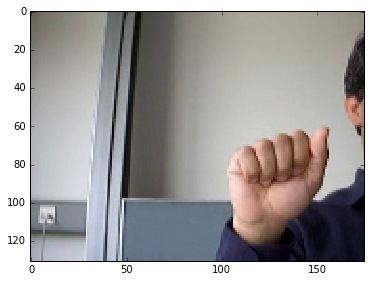

In [173]:
io.imshow(rescale(z,0.546875))

In [174]:
rr = rescale(z,0.546875)

In [116]:
rr.shape

(131, 175, 3)

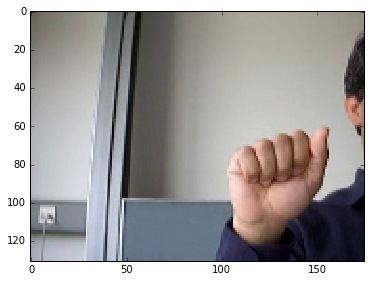

In [119]:
96+128
io.imshow(rr)

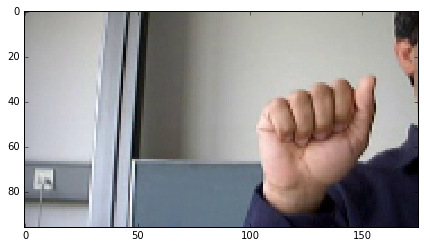

In [127]:
io.imshow(rr[0:0+128][32:32+128])

In [211]:
side = [0 for i in xrange(len(detectedBoxes))]
for i in xrange(len(detectedBoxes)):
    side[i]= 128/scales[i]

for i in xrange(len(detectedBoxes)):
    detectedBoxes[i][0]=detectedBoxes[i][0]/scales[i] #x
    detectedBoxes[i][1]=detectedBoxes[i][1]/scales[i] #y
#     ourBoundingBox = [detectedBoxes[maxidx][0], detectedBoxes[maxidx][1], side[maxidx]]

In [227]:
nms_lis = []
for i in xrange(len(detectedBoxes)):
    nms_lis.append([detectedBoxes[i][0],detectedBoxes[i][1],
                    detectedBoxes[i][0]+side[i],detectedBoxes[i][1]+side[i],detectedBoxes[i][2]])
#[x1,y1,x2,y2]
nms_lis = np.array(nms_lis)
res = non_max_suppression_fast(nms_lis,0.3)
output_det = res[0]
x_top = output_det[0]
y_top = output_det[1]
side1 = output_det[2]-output_det[0]
our = [x_top,y_top,side1]

In [ ]:
import warnings
warnings.filterwarnings('ignore')
get_sree_score(imageset_test,bound_box_test)